In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from matplotlib.widgets import Slider, Button
from joblib import Parallel, delayed 

In [282]:
%load_ext line_profiler

# Problem

Sedimentation Rate

Text(0, 0.5, 'depth')

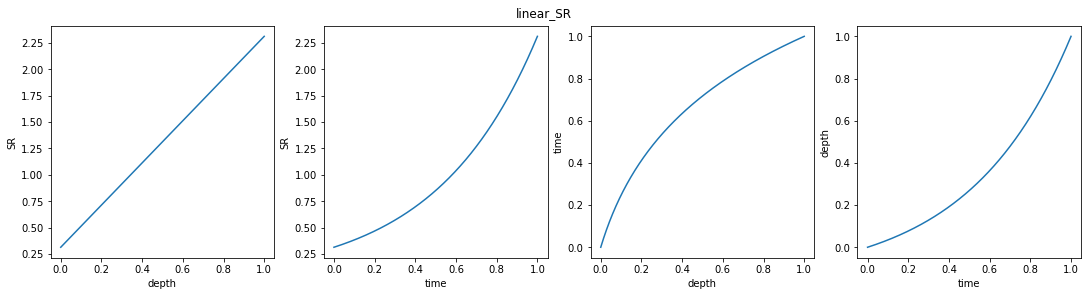

In [3]:
def linear_SR(x, a=2):
    """_summary_

    Args:
        x (depth): 
        a (slope)
    
    Returns:
        linear SR so that depth = 0 and 1 when time = 0 and 1
    """
    b = a/(np.exp(a)-1)
    return a*x + b  

def quadratic_SR(x, a=10):
    """_summary_

    Args:
        x (depth): 
        a (slope): 
        
    
    Returns:
        linear SR so that depth = 0 and 1 when time = and 1
    """
    return 2*a*x - a +1 

def cosntant_SR(x):
    """_summary_

    Args:
        x (array): depth

    Returns:
        cosntant SR
    """
    return np.ones_like(x)

depth = np.linspace(0,1,100000)
func_SR = linear_SR
SR = func_SR(depth)
time = sp.integrate.cumulative_trapezoid(1/SR, depth, initial=0)

fig = plt.figure(figsize=(15,4), constrained_layout=True)
fig.suptitle(f"{func_SR.__name__}")
plt.subplot(1,4,1)

plt.plot(depth, SR)
plt.xlabel("depth")
plt.ylabel("SR")

plt.subplot(1,4,2)
plt.plot(time, SR)
plt.xlabel("time")
plt.ylabel("SR")

plt.subplot(1,4,3)
plt.plot(depth, time)
plt.ylabel("time")
plt.xlabel("depth")


plt.subplot(1,4,4)
plt.plot(time, depth)
plt.xlabel("time")
plt.ylabel("depth")



Inverse of Sedimentation Rate

In [5]:
def linear_inverse_SR(x, a=-0.8):
    """

    Args:
        x (depth): 
        a (slope) from [-1,1]
    
    Returns:
        linear inverse SR so that depth = 0 and 1 when time = 0 and 1
    """
    b = 1 - a
    return a*x + b  


def cosntant_inverse_SR(x):
    """

    Args:
        x (array): depth

    Returns:
        cosntant SR
    """
    return np.ones_like(x)

def sin_inverse_SR(x, A=0.2, k=2):
        
    inv_SR = A*np.cos(2*np.pi*k*x) + 1
    
    return inv_SR

Text(0, 0.5, 'inverse of SR')

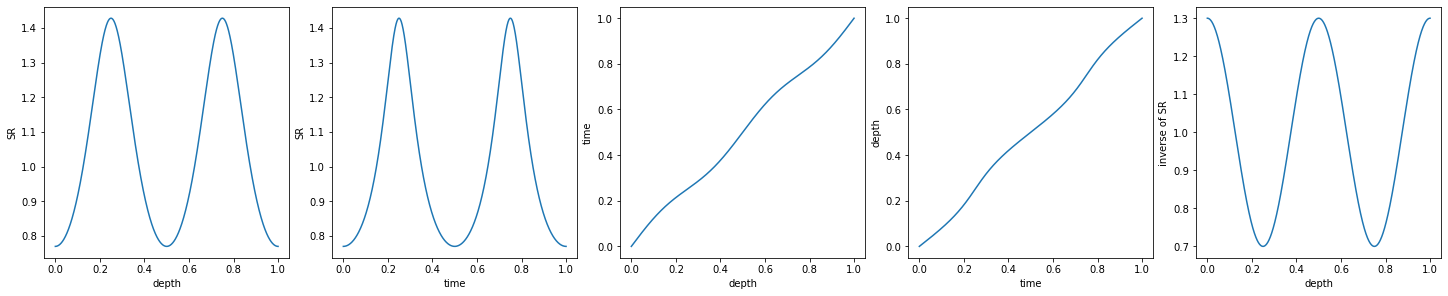

In [6]:
N_data = 1001
depth = np.linspace(0,1,N_data)
func_inv_SR = partial(sin_inverse_SR, A=0.3, k=2)
invSR = func_inv_SR(depth)
SR = 1/invSR
time = sp.integrate.cumulative_trapezoid(1/SR, depth, initial=0)

fig = plt.figure(figsize=(20,4), constrained_layout=True)
# fig.suptitle(f"{func_inv_SR.__name__}")
n = 5

plt.subplot(1,n,1)

plt.plot(depth, SR)
plt.xlabel("depth")
plt.ylabel("SR")

plt.subplot(1,n,2)
plt.plot(time, SR)
plt.xlabel("time")
plt.ylabel("SR")

plt.subplot(1,n,3)
plt.plot(depth, time)
plt.ylabel("time")
plt.xlabel("depth")


plt.subplot(1,n,4)
plt.plot(time, depth)
plt.xlabel("time")
plt.ylabel("depth")

plt.subplot(1,n,5)

plt.plot(depth, invSR)
plt.xlabel("depth")
plt.ylabel("inverse of SR")


Data Generation

In [2]:
b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.022
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
p0 = 50.467718
muy_k = muy_k/180/3600*np.pi
muy_k = muy_k*1e6
p0 = p0/180/3600*np.pi
p0 = p0*1e6

phi_k = phi_k/180/3600*np.pi
phi_p = np.pi/2
# b_k


In [3]:
# def lin_model_gen(AB_k, times, b_k, muy_k):
#     A_k, B_k = AB_k[:len(AB_k)//2], AB_k[len(AB_k)//2:]
#     ts_cos = A_k[None]*b_k[None]*np.sin(muy_k[None]*times[:,None])
#     ts_sin = B_k[None]*b_k[None]*np.cos(muy_k[None]*times[:,None])
#     return np.sum(ts_cos+ts_sin, axis=1)
# def lin_model_gen(AB_k, times, b_k, muy_k):
#     A_k, B_k = AB_k[:len(AB_k)//2], AB_k[len(AB_k)//2:]
#     ts_cos = A_k[None]*b_k[None]*np.sin(muy_k[None]*times[:,None])
#     ts_sin = B_k[None]*b_k[None]*np.cos(muy_k[None]*times[:,None])
#     return np.sum(ts_cos+ts_sin, axis=1)

def generate_X_linReg(Amp, freq, times):
    ts_cos = Amp[None]*np.sin(freq[None]*times[:,None])
    ts_sin = Amp[None]*np.cos(freq[None]*times[:,None])
    return np.concatenate([ts_cos, ts_sin], axis=1)


In [8]:
phi_true = np.random.rand(5)*np.pi
ABtrue = np.hstack([np.cos(phi_true), np.sin(phi_true)])
ABtrue = ABtrue*np.hstack([b_k,b_k])
X_true = generate_X_linReg(np.ones_like(muy_k), muy_k+p0, time)
# X = generate_X_linReg(b_k, muy_k+p0, time)

y_EP = X_true @ ABtrue
noise = np.random.randn(N_data)*1
y_model = y_EP
y = y_model + noise


Text(0.5, 0, 'depth')

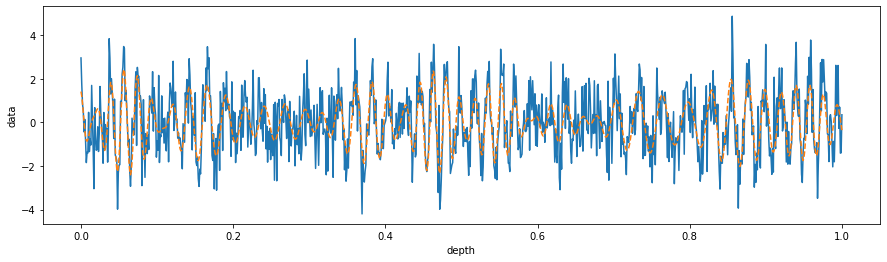

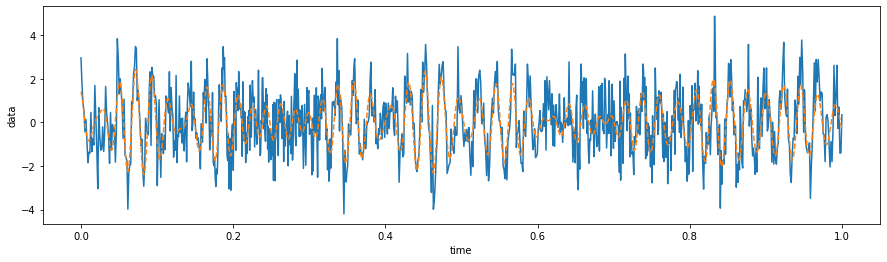

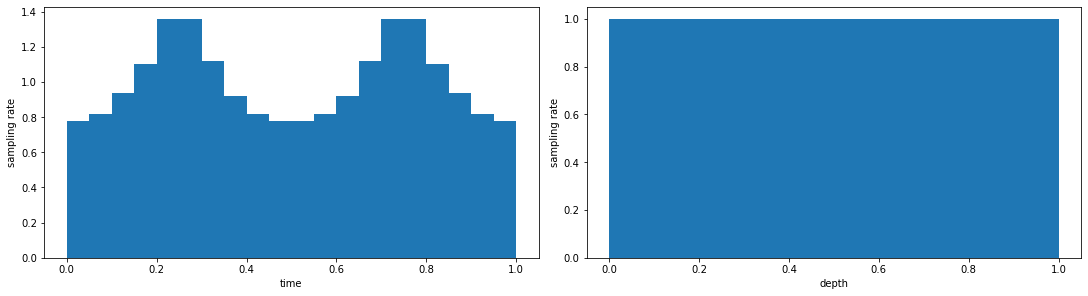

In [192]:
plt.figure(figsize=(15,4))
plt.plot(depth, y)
plt.plot(depth, y_model,'--')
plt.xlabel("depth")
plt.ylabel("data")
plt.figure(figsize=(15,4))
plt.plot(time, y)
plt.plot(time, y_model,'--')
# plt.scatter(time, np.ones_like(time)*-4, s=0.1, color="black")
plt.xlabel("time")
plt.ylabel("data")

fig = plt.figure(figsize=(15, 4), constrained_layout=True)
n = 2
plt.subplot(1,n,1)
plt.hist(time, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("time")
plt.subplot(1,n,2)
plt.hist(depth, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("depth")

Linear regression in time domain 

In [204]:
reg = linear_model.LinearRegression()
X = generate_X_linReg(np.ones_like(muy_k), muy_k+p0, time)
reg.fit(X, y)

print("score R2", reg.score(X,y))
print("AB")
print(ABtrue)
print(reg.coef_)
print("Amplitude")
print("True", ABtrue[:5]**2+ABtrue[5:]**2)
# print(b_k**2)
print("Pred", reg.coef_[:5]**2+reg.coef_[5:]**2)
# b_k**2
print("Phase")
print("True", np.arctan(ABtrue[5:]/ABtrue[:5])/(2*np.pi)*360)
print("Pred", np.arctan(reg.coef_[5:]/reg.coef_[:5])/(2*np.pi)*360)


score R2 0.4972640878256408
AB
[ 0.27854436  0.70253932 -0.57503215 -0.35174862 -0.19275686  0.81681212
  0.24295679  0.14653454  0.19508892  0.01135307]
[ 0.21633494  0.76560501 -0.51797839 -0.39007667 -0.22007157  0.93465545
  0.18306521  0.10970416  0.11442621 -0.0759919 ]
Amplitude
True [0.744769   0.5525895  0.35213435 0.16178678 0.0372841 ]
Pred [0.92038162 0.6196639  0.28033662 0.16525317 0.05420626]
Phase
True [ 71.16990563  19.0767468  -14.2963215  -29.01388782  -3.37073406]
Pred [ 76.96783584  13.44760646 -11.95813231 -16.34867498  19.05007017]


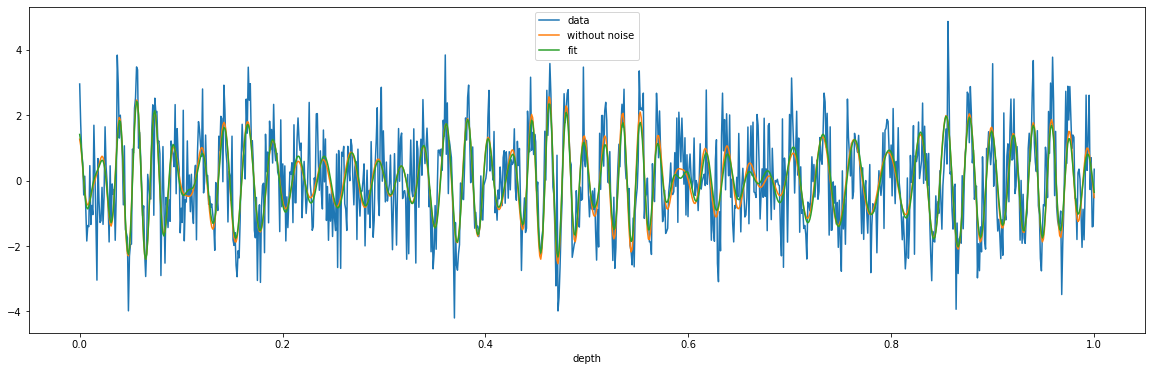

In [205]:
y_true = X @ ABtrue
y_pred = X @ reg.coef_

plt.figure(figsize=(20,6))
plt.plot(depth, y, label="data")
plt.plot(depth, y_pred, label="without noise")
plt.plot(depth, y_true, label="fit")
plt.xlabel("depth")
plt.legend()

LR when SR is assumed to be constant

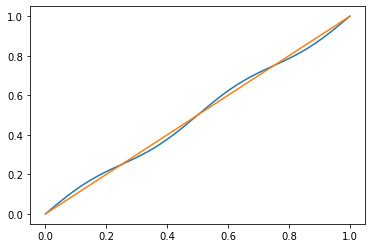

In [210]:
time_constant_SR = depth*1
plt.plot(depth, time)
plt.plot(depth, time_constant_SR)

In [206]:
reg = linear_model.LinearRegression()
X = generate_X_linReg(np.ones_like(muy_k), muy_k+p0, time_constant_SR)
reg.fit(X, y)
print(reg.coef_)
print(ABtrue)
print("Amplitude")
print("True", ABtrue[:5]**2+ABtrue[5:]**2)
# print(b_k**2)
print("Pred", reg.coef_[:5]**2+reg.coef_[5:]**2)
# b_k**2
print("Phase")
print("True", np.arctan(ABtrue[5:]/ABtrue[:5])/(2*np.pi)*360)
print("Pred", np.arctan(reg.coef_[5:]/reg.coef_[:5])/(2*np.pi)*360)



[ 0.11434198  0.16035448 -0.17799096 -0.07921386 -0.01420868  0.3486472
  0.02356304 -0.22526108  0.62813036 -0.11244914]
[ 0.27854436  0.70253932 -0.57503215 -0.35174862 -0.19275686  0.81681212
  0.24295679  0.14653454  0.19508892  0.01135307]
Amplitude
True [0.744769   0.5525895  0.35213435 0.16178678 0.0372841 ]
Pred [0.13462896 0.02626878 0.08242334 0.40082258 0.01284669]
Phase
True [ 71.16990563  19.0767468  -14.2963215  -29.01388782  -3.37073406]
Pred [ 71.84263138   8.35941576  51.68583071 -82.81234186  82.79846904]


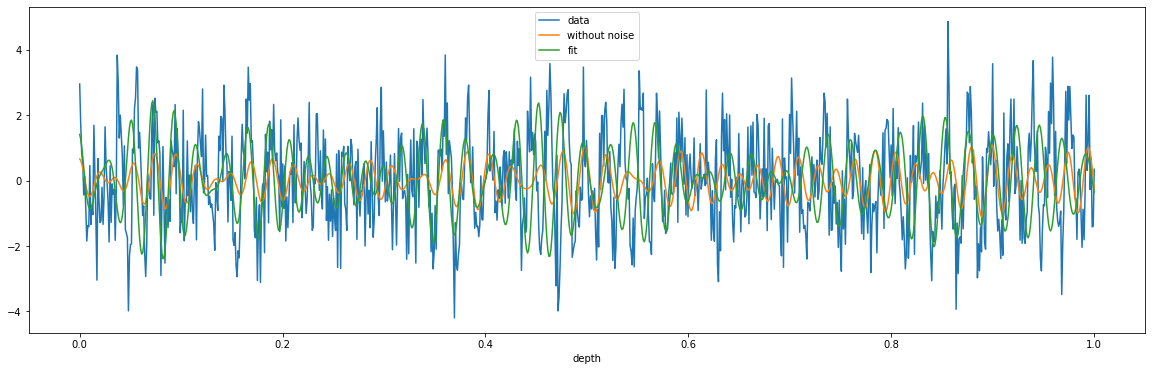

In [208]:
y_true = X @ ABtrue
y_pred = X @ reg.coef_

plt.figure(figsize=(20,6))
plt.plot(depth, y, label="data")
plt.plot(depth, y_pred, label="without noise")
plt.plot(depth, y_true, label="fit")
plt.xlabel("depth")
plt.legend()

# Genetic Algorithm

## Specification

### Selection and metric

In [9]:
def selection_tournament(fits, n, k=2, elitism=True):
    """
    input: fits - the fitness of the populations
           k - size of the tournament
           n - size of the selected individuals
    Randomly select k participants for the tournaments, pick the best amongst k participants
    Repeat n times the tournaments to obtain n winners
    If elitism is True: always retain the best individual
    output: indexes of n selected individuals by the tournament
    """
    inds = np.arange(len(fits))
    inds_tnm = np.random.choice(inds, (n,k))
    winner_results = np.argmax(fits[inds_tnm], 1)
    inds_winner =np.choose(winner_results, inds_tnm.T)
    if elitism:
        arg_best = np.argmax(fits)
        if arg_best not in inds_winner:
            inds_winner[np.random.choice(n)] = arg_best
    return inds_winner
selection_tournament(np.linspace(0,1,11), 10)

array([ 6, 10,  9,  7, 10, 10,  9,  8,  4,  7])

In [10]:
def zero_function(x):
    return x*0

def metric(SR, interpolate_SR, data, fs, metric_type="BIC", *args, **kwargs):
    """
    Input
    SR (2,n):  sedimetation rates and corresponding depth
    data (2,n): the data and corresponding depth
    fs: list of frequencies of the model
    metric_type: "BIC", "AIC" or "RSS"
    k=3: cubic spline (with b-spline representation)
    s: smoothing parameters, s=0: no smooth
    td: time_depth function
    """
    depth, y_data = data
    # spl_SR = splrep(*SR, *args, **kwargs)
    # SR_interpolate = splev(depth, spl_SR)
    SR_interpolate = interpolate_SR(SR, depth)
    eps = 1e-5
    SR_interpolate[SR_interpolate<=0] = eps
    
    time = sp.integrate.cumulative_trapezoid(1/SR_interpolate, depth, initial=0)
    # X = np.concatenate([np.cos(np.array(fs)[None]*t[:,None]), np.sin(np.array(fs)[None]*time[:,None])], axis=1)
    X = generate_X_linReg(np.ones_like(fs), fs, time)

    reg_model = LinearRegression().fit(X, y_data)
    # Residual Sum Square
    RSS = np.sum((y_data - reg_model.predict(X))**2)
    N = len(y_data)
    n_params_SR = len(SR[0])
    n_params = n_params_SR*2 + 1 + len(fs)*2 + 2 
    if metric_type == "BIC":
        coef = np.log(N)
    elif metric_type == "AIC":
        coef = 2
    elif metric_type == "RSS":
        coef = 0
    metric = N*np.log(RSS/N) + coef*n_params
    return metric
    
def interpolate_BSpline(SR, depth):
    spl_SR = splrep(*SR)
    SR_interpolate = splev(depth, spl_SR)
    return SR_interpolate

def interpolate_CubicSpline(SR, depth):
    spl_SR = CubicSpline(*SR)
    SR_interpolate = spl_SR(depth)
    return SR_interpolate
    
def interpolate_SR_Akima(SR, depth):
    # spl_SR = Akima1DInterpolator(*SR)
    # SR_interpolate = spl_SR(depth)
    if len(SR[0]) == 2:
        slope = (SR[1,1]-SR[1,0])/(SR[0,1]-SR[0,0])
        SR_interpolate = slope*depth + SR[1,0]
    else:
        SR_interpolate = Akima1DInterpolator(SR[0],SR[1])(depth)
    return SR_interpolate
    
interpolate_SR = interpolate_SR_Akima
def metric_pop(SRs, interpolate_SR, depth, data, fs, metric_type="BIC", *args, **kwargs):
    return np.array([metric(SR, depth, data, fs, metric_type, interpolate_SR, *args, **kwargs) for SR in SRs]) 

# yp = np.gradient(t, depth[1]-depth[0])
metric([depth[::100], y[::100]], interpolate_SR, [depth, y], muy_k+p0)

843.2652091089813

### Crossover

50 50 50 50


'TEST crossover_2points_2d_pop'

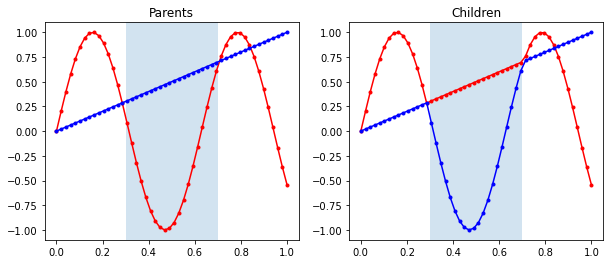

In [18]:
def crossover_2points(x1, x2):
    """ 2-point crossover operation
    input: x1 (n,), x2 (n,) in ascending order
    define randomly an interval in the position of elements 
    swap all the array elements inside the interval of x1 with x2
    return (x1_x, x2_x)
    """
#     if interval is None:
#     interval = np.sort(np.random.rand(2))*(range_data[1]-range_data[0]) + range_data[0]          
#     arg_range1 = np.searchsorted(x1, interval)
#     arg_range2 = np.searchsorted(x2, interval)
    assert len(x1) == len(x2)
    arg_range = np.random.choice(range(len(x1)),2); arg_range.sort()
    x1_x = np.hstack([x1[:arg_range[0]], x2[arg_range[0]:arg_range[1]], x1[arg_range[1]:]] )
    x2_x = np.hstack([x2[:arg_range[0]], x1[arg_range[0]:arg_range[1]], x2[arg_range[1]:]] )
    return [x1_x, x2_x]

def crossover_2points_pop(X, metric_data):
    metric_m = np.min( np.vstack([metric_data[::2],metric_data[1::2]]),axis=0)
    metric_mean = metric_data.mean(); metric_min=metric_data.min()
    pc = np.ones(len(metric_m))
    eps =1e-5
    pc[metric_m<=metric_mean] = (metric_m[metric_m<=metric_mean]-metric_min)/(metric_mean-metric_min + eps) 
    Xx = X.copy()
    for i in range(len(pc)):
        if np.random.rand() < pc[i]:
            Xx[i*2:i*2+2] = np.array(crossover_2points(Xx[i*2],Xx[i*2+1]))
    return Xx


def crossover_2points_2d(x1, x2, interval=None, range_data=[0,1]):
    """ 2-point crossover operation for 2d data
    input: x1= (2,n), x2 (2,m) in ascending order according to the first element (x1[0] and x2[0])
    given / define randomly an interval in range_data 
    swap all the array elements inside the [interval] of x1 with x2
    return (x1_x, x2_x)
    """
    if interval is None:
        interval = np.sort(np.random.rand(2))*(range_data[1]-range_data[0]) + range_data[0]          
    arg_range1 = np.searchsorted(x1[0], interval)
    arg_range2 = np.searchsorted(x2[0], interval)
    x1_x = np.hstack([x1[:,:arg_range1[0]], x2[:,arg_range2[0]:arg_range2[1]], x1[:,arg_range1[1]:]] )
    x2_x = np.hstack([x2[:,:arg_range2[0]], x1[:,arg_range1[0]:arg_range1[1]], x2[:,arg_range2[1]:]] )
    return [x1_x, x2_x]

def crossover_2points_2d_pop(X, fits, interval=None):
    """_summary_
        Perform 2d 2-point crossover of 2 neighboring individuals in population 
        with probability pc = (fmax - f')/(fmax - <f>)        if f' >= <f>
                            = 1                             if f' <  <f>
        where   f' is the larger fitness of the two individuals
                fmax is the maximum fitness in the population
                <f> is the average fitness in the population
        Meaning:    All the individuals having fitness lower than average will be crossed, 
                    Those that good fitness are crossed less (to preserve good genes)
                    Population is crossed more when population getting stagnant (fmax is close to <f>)
                 
        Ref: Adaptive Probabilities of Crossover and Mutation (Srinivas and Patnaik 1994)
    Args:
        X (list[N_population][2, N_genes]): collection of individuals in the population
        metric_data (array[N_population]): metric mesures the fitness of individuals in the population
    Returns:
        _type_: _description_
    """
    fp = np.max(np.vstack([fits[::2],fits[1::2]]),axis=0)
    fmean = fits.mean(); fmax = fits.max()
    pc = np.ones(len(fp))
    eps = 1e-5
    pc[fp>=fmean] = (fmax-fp[fp>=fmean])/(fmax-fmean + eps) 
    for i in range(len(pc)):
        if np.random.rand() < pc[i]:
            X[i*2:i*2+2] = crossover_2points_2d(X[i*2], X[i*2+1], interval=interval)
    return X

"TEST crossover_2points_2d"
x = np.linspace(0,1,50)
x1 = np.vstack([x,np.sin(10*x)])
# x02 = np.sort(np.random.rand(10))
x02 = x
x2 = np.vstack([x02, x02])
interval = np.sort(np.random.rand(2))
interval = [0.3,0.7]
x1_x, x2_x = crossover_2points_2d(x1,x2, interval)
fig, axs =plt.subplots(1,2,figsize=(10,4))
axs[0].plot(x1[0], x1[1], ".-", color="red")
axs[0].plot(x2[0], x2[1], ".-", color="blue")
axs[0].axvspan(*interval, alpha=0.2)
axs[0].set_title("Parents")
axs[1].plot(x1_x[0],x1_x[1], "r.-")
axs[1].plot(x2_x[0], x2_x[1], "b.-")
axs[1].axvspan(*interval, alpha=0.2)
axs[1].set_title("Children")
print(len(x1_x[0]), len(x2_x[0]), len(x1[0]), len(x2[0]))
plt.savefig("figures/crossover.png", dpi=200)
"TEST crossover_2points_2d_pop"
# X = [x1,x2,x1,x2]
# Xx = crossover_2points_2d_pop(X, np.array([1,2,6,7]), interval)
# x1_x, x2_x, _, _ = Xx
# fig, axs =plt.subplots(1,2,figsize=(10,5))
# axs[0].plot(x1[0], x1[1], ".-", color="red")
# axs[0].plot(x2[0], x2[1], ".-", color="blue")
# axs[0].axvspan(*interval, alpha=0.2)
# axs[1].plot(x1_x[0],x1_x[1], "r.-")
# axs[1].plot(x2_x[0], x2_x[1], "b.-")
# axs[1].axvspan(*interval, alpha=0.2)
# print(len(x1_x[0]), len(x2_x[0]), len(x1[0]), len(x2[0]));

20 20 20 20


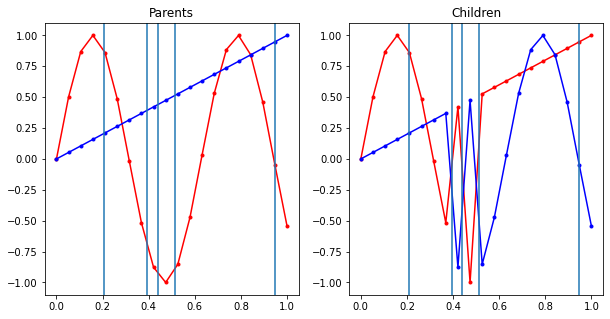

In [13]:
def crossover_kpoints_2d(x1, x2, locus=None, k=2, range_data=[0,1]):
    """_summary_
    k-point crossover operation for 2d data
    input: x1= (2,n), x2 (2,m) in ascending order according to the first element (x1[0] and x2[0])
    given / define randomly an k+1 interval from k locus
    For each interval, choose the genes from either parent 1 or 2 (with equal probability)
    to form 1 child and the the other parent for the other child
    Returns:
        _type_: _description_
    """
    if locus is None:
        locus = np.sort(np.random.rand(k))*(range_data[1]-range_data[0]) + range_data[0]          
    if locus is not None:
        k = len(locus)
    
    arg_range1 = np.searchsorted(x1[0], locus)
    arg_range1 = np.hstack([0, arg_range1, len(x1[0])+1])
    arg_range2 = np.searchsorted(x2[0], locus)
    arg_range2 = np.hstack([0, arg_range2, len(x2[0])+1])
    
    x1_x, x2_x = [], []
    for i in range(k+1):
        intv1 = x1[:, arg_range1[i]:arg_range1[i+1]]
        intv2 = x2[:, arg_range2[i]:arg_range2[i+1]]
        if np.random.rand()<0.5:
            x1_x.append(intv1)
            x2_x.append(intv2)
        else:
            x1_x.append(intv2)
            x2_x.append(intv1)
    
    return [np.hstack(x1_x), np.hstack(x2_x)]


def crossover_pop(X, fits, crossover_operator, *args, **kwargs):
    """_summary_
        Perform 2d 2-point crossover of 2 neighboring individuals in population 
        with probability pc = (fmax - f')/(fmax - <f>)        if f' >= <f>
                            = 1                             if f' <  <f>
        where   f' is the larger fitness of the two individuals
                fmax is the maximum fitness in the population
                <f> is the average fitness in the population
        Meaning:    All the individuals having fitness lower than average will be crossed, 
                    Those that good fitness are crossed less (to preserve good genes)
                    Population is crossed more when population getting stagnant (fmax is close to <f>)
                 
        Ref: Adaptive Probabilities of Crossover and Mutation (Srinivas and Patnaik 1994)
    Args:
        X (list[N_population][2, N_genes]): collection of individuals in the population
        metric_data (array[N_population]): metric mesures the fitness of individuals in the population
    Returns:
        _type_: _description_
    """
    fp = np.max(np.vstack([fits[::2],fits[1::2]]),axis=0)
    fmean = fits.mean(); fmax = fits.max()
    pc = np.ones(len(fp))
    eps = 1e-5
    pc[fp>=fmean] = (fmax-fp[fp>=fmean])/(fmax-fmean + eps) 
    for i in range(len(pc)):
        if np.random.rand() < pc[i]:
            X[i*2:i*2+2] = crossover_operator(X[i*2], X[i*2+1], args, kwargs)
    return X

crossover_operator = crossover_kpoints_2d

"TEST crossover_2points_2d"
x = np.linspace(0,1,20)
x1 = np.vstack([x,np.sin(10*x)])
x2 = np.vstack([x, x])
interval = np.sort(np.random.rand(5))
x1_x, x2_x = crossover_kpoints_2d(x1,x2, interval)
fig, axs =plt.subplots(1,2,figsize=(10,5))
axs[0].plot(x1[0], x1[1], ".-", color="red")
axs[0].plot(x2[0], x2[1], ".-", color="blue")
axs[0].set_title("Parents")
axs[1].plot(x1_x[0],x1_x[1], "r.-")
axs[1].plot(x2_x[0], x2_x[1], "b.-")
for i in range(len(interval)):
    axs[0].axvline(interval[i])
    axs[1].axvline(interval[i])
axs[1].set_title("Children")
print(len(x1_x[0]), len(x2_x[0]), len(x1[0]), len(x2[0]))


In [132]:
a = np.random.rand(2,5)
# a = [[0.51858038, 0.23309125, 0.40657947, 0.12082807, 0.1055776 ], [0.50595171, 0.70217092, 0.69403557, 0.42035356, 0.94515537]]
print(a)
b = [True, False, True, True, False]
# a[:,b]

print(a[[1,0,1,1,0],[0,1,2,3,4]])
# a
# np.random.rand?

[[0.97396071 0.48703522 0.24682911 0.33987258 0.14285368]
 [0.86888549 0.04361868 0.7248873  0.77893504 0.16953124]]
[0.86888549 0.48703522 0.7248873  0.77893504 0.14285368]


### Mutation

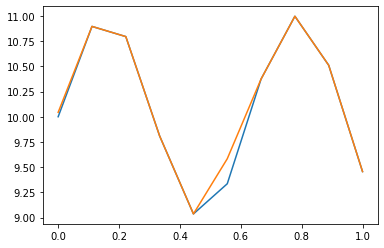

In [14]:
def mutation_v1(x1, pm, xrange=[0,1], yrange=[0,1]):
    """
    input: x1(2,n) is a gene
    pm is probability of mutaion
    cycle through each element of x1:
    with a probability of pm,
    delete the element (50%) or 
    randomly create a new element (50%) 
    output: new x1
    """
    
    x1_m = x1.copy()
    n = len(x1[0])
    bool_m = np.random.rand(n) < pm
    arg_m  = np.argwhere(bool_m)[:,0]
    bool_del = np.random.rand(len(arg_m)) < 0.5
    arg_del = arg_m[bool_del]
    new_ele = np.random.rand(2,len(arg_m)-len(arg_del))
    new_ele[0] = new_ele[0]*(xrange[1] - xrange[0]) + xrange[0]
    new_ele[1] = new_ele[1]*(yrange[1] - yrange[0]) + yrange[0]
    x1_m = np.delete(x1_m, arg_del, axis=1)
    x1_m = np.hstack([x1_m, new_ele])
    x1_m = x1_m[:,np.argsort(x1_m[0])]
    return x1_m



def mutation_v1_pop(X, metric_X, xrange=[0,1], yrange=[0,1]):
    metric_mean = metric_X.mean(); metric_min=metric_X.min()
    pm = np.ones(len(metric_X))*0.5
    eps=1e-5
    pm[metric_X<=metric_mean] = (metric_X[metric_X<=metric_mean]-metric_min)/(metric_mean-metric_min + eps) 
#     print(pm)
    Xm = np.array([mutation_v1(X[i], pm[i], xrange, yrange) for i in range(len(X))])
    return Xm


def mutation_poly(x1, pm, xrange=[0,1], eta=50):
    """
    Polynomial Mutation (Deb and Deb 2014)
    input: x1(n, ) is a gene
    pm is probability of mutaion
    output: new x1
    """
    x1_m = x1.copy()
    n = len(x1)
    bool_m = np.random.rand(n) < pm
    arg_m  = np.argwhere(bool_m)[:,0]
    u = np.random.rand(len(arg_m))
    arg_m_L = arg_m[u<=0.5]
    arg_m_R = arg_m[u>0.5]
    # print(x1.shape, arg_m_R.shape, x1_m[arg_m_R].shape, u.shape)
    if len(arg_m_L) > 0:
        delta_L = (2*u[u<=0.5])**(1/(1+eta))-1
        x1_m[arg_m_L] = x1_m[arg_m_L] + delta_L*(x1_m[arg_m_L] - xrange[0])
    if len(arg_m_R) > 0:
        delta_R = 1-(2*(1-u[u>0.5]))**(1/(1+eta))
        x1_m[arg_m_R] = x1_m[arg_m_R] + delta_R*(-x1_m[arg_m_R] + xrange[1])
    return x1_m
    
def mutation_poly_pop(X, metric_X, xrange=[0,1], eta=50):
    metric_mean = metric_X.mean(); metric_min=metric_X.min()
    pm = np.ones(len(metric_X))*0.5
    eps=1e-5
    pm[metric_X<=metric_mean] = (metric_X[metric_X<=metric_mean]-metric_min)/(metric_mean-metric_min + eps)*0.5
#     print(pm)
    Xm = np.array([mutation_poly(X[i], pm[i], xrange, eta) for i in range(len(X))])
    return Xm

def mutation_poly_2d(x, pm, xrange=[0,1], yrange=[0,1], eta=50):
    """
    Polynomial Mutation (Deb and Deb 2014)
    input: individual x(2, n) having n genes of dim 2
    pm is probability of mutaion
    output: new x
    """
    x_m = x.copy()
    n = len(x[0])
    bool_m = np.random.rand(n) < pm
    arg_m  = np.argwhere(bool_m)[:,0]
    u = np.random.rand(len(arg_m))
    arg_m_L = arg_m[u<=0.5]
    arg_m_R = arg_m[u>0.5]
    delta_L = (2*u[u<=0.5])**(1/(1+eta))-1
    delta_R = 1-(2*(1-u[u>0.5]))**(1/(1+eta))
    
    
    x_m[0, arg_m_L] = x_m[0, arg_m_L] + delta_L*(x_m[0, arg_m_L] - xrange[0])
    x_m[0, arg_m_R] = x_m[0, arg_m_R] + delta_R*(-x_m[0, arg_m_R] + xrange[1])
    
    x_m[1, arg_m_L] = x_m[1, arg_m_L] + delta_L*(x_m[1, arg_m_L] - yrange[0])
    x_m[1, arg_m_R] = x_m[1, arg_m_R] + delta_R*(-x_m[1, arg_m_R] + yrange[1])
    return x_m



# x = np.linspace(0,1,30)
# x1 = np.vstack([x,np.sin(10*x)])
# x1_x = mutation_v1(x1, 0.5, yrange=[-1,1])
# plt.plot(x1[0],x1[1], ".-")
# plt.plot(x1_x[0],x1_x[1],'.-')
# print(len(x1[0]), len(x1_x[0]))

# TEST mutation_poly
x = np.linspace(0,1,10)
x1 = np.sin(10*x)+10
x1_x = mutation_poly(x1, 0.1, xrange=[0,20], eta=50)
plt.plot(x, x1)
plt.plot(x,x1_x)
# plt.plot(x, x1-x1_x)
# plt.plot(x1_x[0],x1_x[1])

#TEST mutation_poly_pop
# x = np.linspace(0,1,50)
# x1 = np.sin(10*x)+10
# X = np.vstack([x1,x1,x1,x1])
# X_x = mutation_poly_pop(X, np.array([0,1,1,1]), xrange=[0,20], eta=50)
# # fig, axs = plt.figure(1,3)
# plt.plot(x, x1)
# plt.plot(x, X_x[0],'--')
# plt.plot(x, X_x[1],'--')



30 30


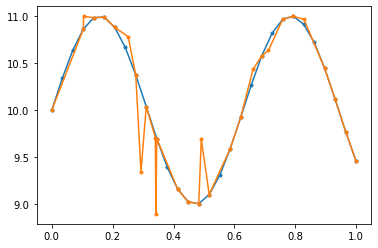

In [16]:
def mutation_v2(x, pm, xrange=[0,1], yrange=[0,1], pdel=0.2, padd=0.2, pmut=0.6, eta=50, alpha=0.1):
    """
    input: x1(2,n) is a gene
    pm is probability of mutaion
    cycle through each element of x1:
    with a probability of pm, either
    delete the element (pdel, 20%) or
    create new element (uniformly sampled in the possible range) (padd, 20%)
    locally mutate (with polynomial rule)
    output: new x1
    """
    
    x_m = x.copy()
    n = len(x[0])
    bool_m = np.random.rand(n-2) < pm
    arg_m  = np.argwhere(bool_m)[:,0]+1
    
    assert pdel + padd + pmut == 1 
    rand = np.random.rand(len(arg_m))
    bool_del = rand <= pdel
    bool_add = (rand > pdel) & (rand < padd+pdel)  
    bool_loc_mut = rand >= padd+pdel
    
    
    arg_loc_mut = arg_m[bool_loc_mut]
    x_m[:, arg_loc_mut] = mutation_poly_2d(x_m[:, arg_loc_mut], 1, xrange, yrange, eta)
    
    
    # MUTATION AT BOUNDARY
    if np.random.rand() < pm :
        x_m[1,0] = mutation_poly(x_m[1, :1], 1, yrange, eta)[0]
    if np.random.rand() < pm :
        x_m[1,-1] = mutation_poly(x_m[1, -1:], 1, yrange, eta)[0]
    # print(x_m[1,0], x_m[1,-1])
    arg_del = arg_m[bool_del]
    x_m = np.delete(x_m, arg_del, axis=1)
    
    
    min_y = x[1,:].min(); max_y = x[1,:].max()    
    min_range = max(min_y-(max_y-min_y)*alpha, yrange[0])
    max_range = min(max_y+(max_y-min_y)*alpha, yrange[1])
    new_ele = np.random.rand(2, sum(bool_add))
    new_ele[0] = new_ele[0]*(xrange[1] - xrange[0]) + xrange[0]
    new_ele[1] = new_ele[1]*(max_range-min_range)  + min_range
    x_m = np.hstack([x_m, new_ele])
    
    x_m = x_m[:,np.argsort(x_m[0])]
    return x_m


def mutation_v2_pop(X, fits, xrange=[0,1], yrange=[0,1], pdel=0.2, padd=0.2, pmut=0.6, eta=50, alpha=0.1):
    """_summary_
        Perform mutation_v2 for each individual in the population X
        with probability pm = (fmax - f')/(fmax - <f>)        if f' >= <f>
                            = 1                             if f' <  <f>
        where   f' is the larger fitness of the two individuals
                fmax is the maximum fitness in the population
                <f> is the average fitness in the population
        Meaning:    All the individuals having fitness lower than average will be crossed, 
                    Those that good fitness are crossed less (to preserve good genes)
                    Population is crossed more when population getting stagnant (fmax is close to <f>)
                 
        Ref: Adaptive Probabilities of Crossover and Mutation (Srinivas and Patnaik 1994)
    Args:
        X (list[N_population][2, N_genes]): collection of individuals in the population
        metric_data (array[N_population]): metric mesures the fitness of individuals in the population
    Returns:
        _type_: _description_
    """
    
    fmean = fits.mean(); fmax=fits.max()
    pm = np.ones(len(fits))*0.5
    eps=1e-5
    pm[fits>=fmean] = 0.5*(fmax - fits[fits>=fmean]) / (fmax - fmean + eps) 
#     print(pm)
    Xm = [mutation_v2(X[i], pm[i], xrange, yrange, pdel, padd, pmut, eta, alpha) for i in range(len(X))]
    return Xm

#TEST mutation_v2
x = np.linspace(0,1,30)
x1 = np.vstack([x,np.sin(10*x)+10])
x1_x = mutation_v2(x1, 0.5, yrange=[0,20])
plt.figure()
plt.plot(x1[0],x1[1], ".-")
plt.plot(x1_x[0],x1_x[1],'.-')
print(len(x1[0]), len(x1_x[0]))


#TEST mutation_poly_pop
# x = np.linspace(0,1,30)
# x1 = np.vstack([x,np.sin(10*x)+10])
# X = [x1,x1,x1,x1]
# X_x = mutation_v2_pop(X, np.array([0,1,1,1]), yrange=[0,20], eta=50)
# plt.figure()
# plt.plot(X_x[0][0], X_x[0][1], '.-')
# plt.plot(X_x[1][0], X_x[1][1], '.-')

# plt.plot(x, X_x[1],'--')

In [67]:
x1_x[1]

array([ 0.11003551, 10.6362712 , 10.85959818, 10.75689332, 10.9882662 ,
       10.87845883, 10.6652283 ,  9.62111077,  9.69810173, 10.71224578,
        9.39361157,  9.16051303,  9.0262494 ,  9.00662787,  9.30678238,
       10.02290134,  9.92378522, 10.26532292,  8.95039562, 10.57562349,
       10.81815446, 10.94504431, 10.9970329 , 10.91232056, 10.80136907,
       10.44328555, 10.29349624,  9.77163843,  0.99987687])

## Problem

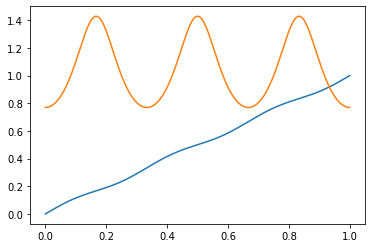

In [17]:
N_data = 1001
depth = np.linspace(0,1,N_data)
func_inv_SR = partial(sin_inverse_SR, A=0.3, k=3)
# func_inv_SR = cosntant_inverse_SR
# func_inv_SR = linear_inverse_SR
invSR = func_inv_SR(depth)
SR = 1/invSR
time = sp.integrate.cumulative_trapezoid(1/SR, depth, initial=0)
plt.plot(depth, time)
plt.plot(depth, SR)

Text(0.5, 0, 'depth')

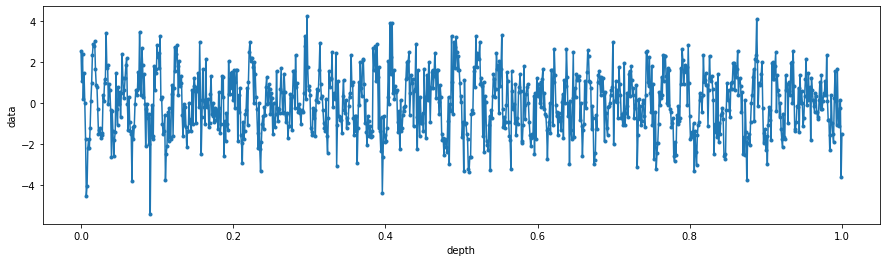

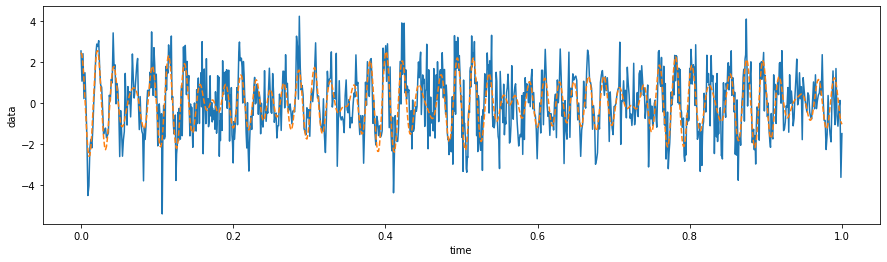

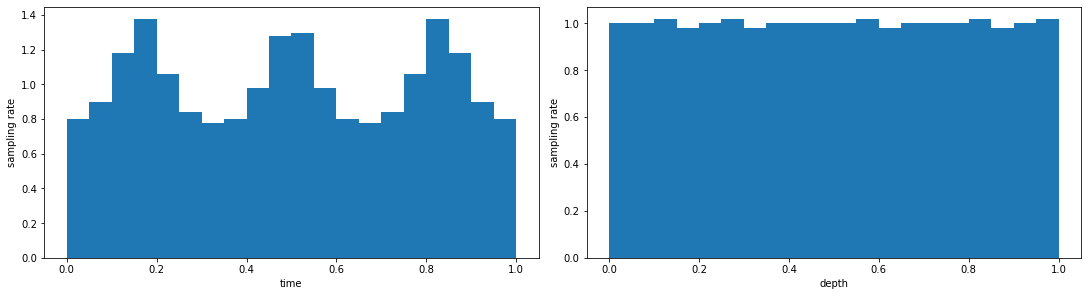

In [18]:
phi_true = np.random.rand(5)*np.pi
ABtrue = np.hstack([np.cos(phi_true), np.sin(phi_true)])
ABtrue = ABtrue*np.hstack([b_k,b_k])
X_true = generate_X_linReg(np.ones_like(muy_k), muy_k+p0, time)
# X = generate_X_linReg(b_k, muy_k+p0, time)

y_EP = X_true @ ABtrue
noise = np.random.randn(N_data)*1
y_model = y_EP
y = y_model + noise

plt.figure(figsize=(15,4))
plt.plot(depth, y, '.-')
# plt.plot(depth, y_model,'--')
plt.xlabel("depth")
plt.ylabel("data")
plt.figure(figsize=(15,4))
plt.plot(time, y)
plt.plot(time, y_model,'--')
# plt.scatter(time, np.ones_like(time)*-4, s=0.1, color="black")
plt.xlabel("time")
plt.ylabel("data")

fig = plt.figure(figsize=(15, 4), constrained_layout=True)
n = 2
plt.subplot(1,n,1)
plt.hist(time, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("time")
plt.subplot(1,n,2)
plt.hist(depth, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("depth")

## Train

In [28]:

N_population = 500 # number of individual in population 
N_generations_max = 100
N_genes = 10 # number of intial gene in an individial of the population 
depth_grid = np.linspace(0,1,N_genes)
# k = 1 # degree of spline
# depth_grid = 0.5 + 0.5*np.cos((2*(np.arange(N_genes)+1)-1)/(2*N_genes)*np.pi); depth_grid = depth_grid[::-1]
SR_lims = [0, 3]
smooth = N_genes*0
# BICs_all = np.zeros((n_generations_max-1,K))
# SR_all = np.zeros((N_generations_max, K, N_genes))
SR_all = []
def generate_SR_ini(N_genes, SR_lims):
    SR_ini = [np.vstack([np.sort(np.hstack([np.random.rand(N_genes-2), [0,1]])),
                        np.random.rand(N_genes)*SR_lims[1]])
            for i in range(N_population)]
    # SR_ini = [np.vstack([np.linspace(0,1,N_genes),  
    #                     np.random.rand(N_genes)*SR_lims[1]])
            # for i in range(N_population)]
    SR_ini[:][1] = SR_ini[:][1]*SR_lims[1]
    return SR_ini
SR_ini = generate_SR_ini(N_genes, SR_lims)
SR_all += [SR_ini]
# metric = metric_Akima
interpolate_SR = interpolate_SR_Akima
interpolate_SR = interpolate_CubicSpline
metric_all = np.zeros((N_generations_max, N_population))
metric_type =  "BIC"
metric_ini = np.array([metric(SR_ini_i, interpolate_SR, [depth, y], muy_k+p0, metric_type=metric_type) for SR_ini_i in SR_ini])
metric_all[0] = metric_ini
crossover_operator = crossover_kpoints_2d
# [plt.plot(SR_ini[i][0], SR_ini[i][1]) for i in range(10)];


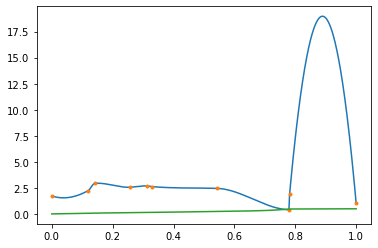

In [24]:
ix = 3

eps = 1e-5
SR_interpolate = interpolate_SR(SR_ini[ix], depth)
SR_interpolate[SR_interpolate<=0] = eps

time_x = sp.integrate.cumulative_trapezoid(1/SR_interpolate, depth, initial=0)
plt.plot(depth, SR_interpolate)
# plt.plot(depth, 1/SR_interpolate)
plt.plot(*SR_ini[ix],'.')
# plt.ylim([0,10])
plt.plot(depth, time_x)

In [29]:

def train():
    SR_ini = generate_SR_ini(15, SR_lims)
    SR_all = [SR_ini]
    metric_all = np.zeros((N_generations_max, N_population))
    metric_type =  "BIC"
    metric_ini = np.array([metric(SR_ini_i, interpolate_SR, [depth, y], muy_k+p0, metric_type=metric_type) for SR_ini_i in SR_ini])
    metric_all[0] = metric_ini
    n_generations = N_generations_max
    for i in trange(N_generations_max-1):
    #     print(i)
        SR_i = SR_all[i]
        metric_i = metric_all[i]
        if metric_i.min() ==  metric_i.max():
            n_generations = i+1
            break
        selected_inds = selection_tournament(-metric_i, N_population, 2, elitism=True)
        SR_i = [SR_i[ind] for ind in selected_inds] 
        SR_ip = crossover_pop(SR_i, -metric_i[selected_inds], crossover_operator, k=5)
        metric_ip = np.array([metric(SR_i_j , interpolate_SR, [depth, y], muy_k+p0, metric_type=metric_type) for SR_i_j in SR_ip])
        SR_ip = mutation_v2_pop(SR_ip, -metric_ip, xrange=[0,1], yrange=[0,3], eta=20)
        metric_ip = np.array([metric(SR_i_j , interpolate_SR, [depth, y], muy_k+p0, metric_type=metric_type) for SR_i_j in SR_ip])
        metric_all[i+1] = metric_ip
        SR_all += [SR_ip]
    SR_all, metric_all = SR_all[:n_generations], metric_all[:n_generations]
    return SR_all, metric_all
# SR_all,metric_all = train()
# n_jobs 
res = Parallel(n_jobs=50)(delayed(train)() for i in range(50))
SR_all_para = [item[0] for item in res]
metric_para =[ item[1] for item in res]
# %lprun -f train train()

  0%|          | 0/99 [00:00<?, ?it/s]  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]


In [497]:
eps = 1e-4
n_generations = N_generations_max
for i in trange(N_generations_max-1):
#     print(i)
    SR_i = SR_all[i]
    metric_i = metric_all[i]
    if metric_i.min() ==  metric_i.max():
        n_generations = i+1
        break
    selected_inds = selection_tournament(-metric_i, N_population, 2, elitism=True)
    SR_i = [SR_i[ind] for ind in selected_inds] 
    SR_ip = crossover_pop(SR_i, -metric_i[selected_inds], crossover_operator, k=5)
    metric_ip = np.array([metric(SR_i_j , interpolate_SR, [depth, y], muy_k+p0, metric_type=metric_type) for SR_i_j in SR_ip])
    SR_ip = mutation_v2_pop(SR_ip, -metric_ip, xrange=[0,1], yrange=[0,3], eta=20)
    metric_ip = np.array([metric(SR_i_j , interpolate_SR, [depth, y], muy_k+p0, metric_type=metric_type) for SR_i_j in SR_ip])
    metric_all[i+1] = metric_ip
    SR_all += [SR_ip]
print(n_generations)
metric_all = metric_all[:n_generations]
SR_all = SR_all[:n_generations]


  0%|          | 0/99 [00:00<?, ?it/s]

IndexError: index 71 is out of bounds for axis 0 with size 71

### Result

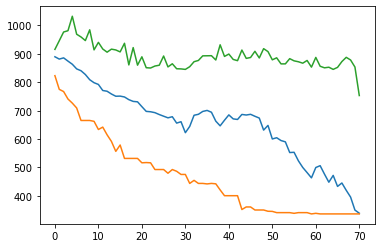

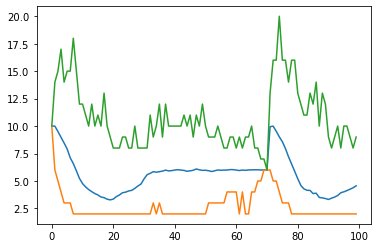

In [498]:
plt.figure()
# metric_all = metric_all[:n_generations]
plt.plot(metric_all.mean(axis=1))
plt.plot(metric_all.min(axis=1))
plt.plot(metric_all.max(axis=1))
len_td = np.array([[SR_all[j][i].shape[1] for i in range(N_population) ] for j in range(n_generations) ])
plt.figure()
plt.plot(len_td.mean(axis=1))
plt.plot(len_td.min(axis=1))
plt.plot(len_td.max(axis=1))

In [332]:
SR_all[-1][3]

array([[0.        , 1.        ],
       [0.56746   , 1.00004988]])

184


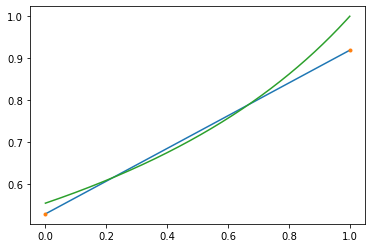

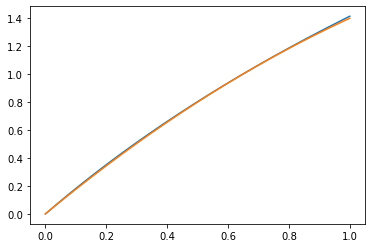

In [483]:
ix = np.random.randint(N_population)
# ix = 0
print(ix)
SR_x = SR_all[-1][ix]

SR_interpolate = interpolate_SR(SR_x, depth)
eps = 1e-5
SR_interpolate[SR_interpolate<=0] = eps

time_x = sp.integrate.cumulative_trapezoid(1/SR_interpolate, depth, initial=0)
plt.plot(depth, SR_interpolate)
# plt.plot(depth, 1/SR_interpolate)
plt.plot(*SR_x,'.')
plt.plot(depth, SR)
# plt.ylim([0,3])
plt.figure()
plt.plot(depth, time_x)
plt.plot(depth, time)

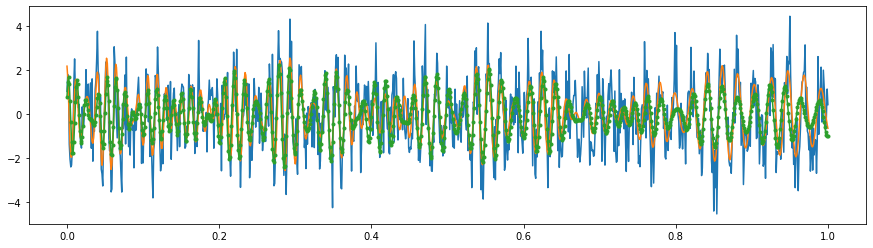

In [484]:
# depth, y_data = data
# spl_SR = splrep(*SR, *args, **kwargs)
# SR_interpolate = splev(depth, spl_SR)
SR_x = SR_all[-1][ix]
SR_interpolate = interpolate_SR(SR_x, depth)
eps = 1e-5
SR_interpolate[SR_interpolate<=0] = eps

time = sp.integrate.cumulative_trapezoid(1/SR_interpolate, depth, initial=0)
# X = np.concatenate([np.cos(np.array(fs)[None]*t[:,None]), np.sin(np.array(fs)[None]*time[:,None])], axis=1)
fs = muy_k+p0
X = generate_X_linReg(np.ones_like(fs), fs, time)
reg_model = LinearRegression().fit(X, y)
# Residual Sum Square
plt.figure(figsize=(15,4))
plt.plot(depth, y)
plt.plot(depth, y_model)
plt.plot(depth, reg_model.predict(X), '.-')


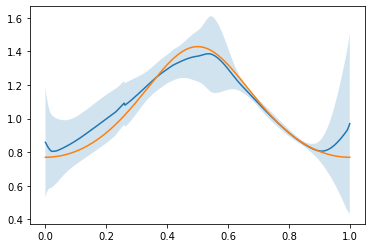

In [538]:
SR_interpolate_par = np.array([interpolate_SR(SR_all[-1][ix], depth) for SR_all in SR_all_para])
# SR_interpolate_par.shape
mean_SR = SR_interpolate_par.mean(axis=0); std_SR = SR_interpolate_par.std(axis=0)
plt.plot(depth, mean_SR)
plt.fill_between(depth, mean_SR-std_SR, mean_SR+std_SR, alpha=0.2)
plt.plot(depth, SR)

In [562]:
# SR_interpolate_par.shape
len(SR_all_para[2][0][0])

2

(array([ 4.,  3., 26., 17., 21., 17.,  5.,  7.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 8 artists>)

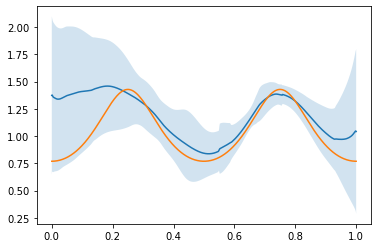

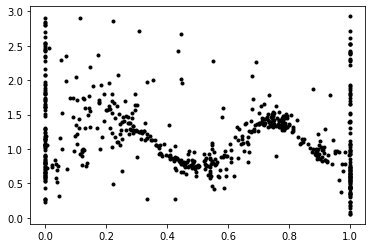

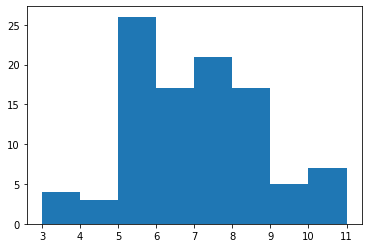

In [578]:
SR_interpolate_par = np.array([interpolate_SR(SR_all[-1][0], depth) for SR_all in SR_all_para])
n_SR_par = np.array([len(SR_all[-1][0][0]) for SR_all in SR_all_para])
SR_par = [SR_all[-1][0] for SR_all in SR_all_para]
# SR_interpolate_par.shape
mean_SR = SR_interpolate_par.mean(axis=0); std_SR = SR_interpolate_par.std(axis=0)
plt.plot(depth, mean_SR)
plt.fill_between(depth, mean_SR-std_SR, mean_SR+std_SR, alpha=0.2)
plt.plot(depth, SR)
plt.figure()
[plt.plot(*SRi, ".", color="black") for SRi in SR_par]
plt.figure()
plt.hist(n_SR_par, bins=8)


(array([ 6., 18.,  0.,  8.,  9.,  0.,  6.,  3.]),
 array([2.   , 2.625, 3.25 , 3.875, 4.5  , 5.125, 5.75 , 6.375, 7.   ]),
 <BarContainer object of 8 artists>)

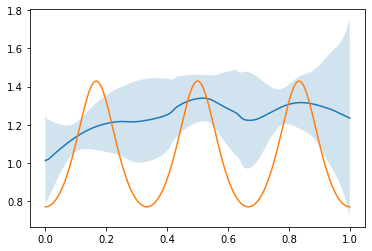

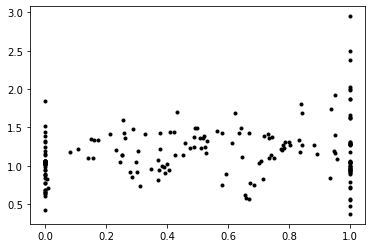

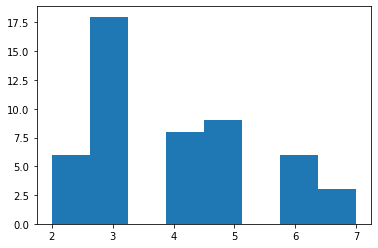

In [27]:
SR_interpolate_par = np.array([interpolate_SR(SR_all[-1][0], depth) for SR_all in SR_all_para])
n_SR_par = np.array([len(SR_all[-1][0][0]) for SR_all in SR_all_para])
SR_par = [SR_all[-1][0] for SR_all in SR_all_para]
# SR_interpolate_par.shape
mean_SR = SR_interpolate_par.mean(axis=0); std_SR = SR_interpolate_par.std(axis=0)
plt.plot(depth, mean_SR)
plt.fill_between(depth, mean_SR-std_SR, mean_SR+std_SR, alpha=0.2)
plt.plot(depth, SR)
plt.figure()
[plt.plot(*SRi, ".", color="black") for SRi in SR_par]
plt.figure()
plt.hist(n_SR_par, bins=8)


(array([81.,  4.,  0.,  8.,  4.,  0.,  1.,  2.]),
 array([2.   , 2.625, 3.25 , 3.875, 4.5  , 5.125, 5.75 , 6.375, 7.   ]),
 <BarContainer object of 8 artists>)

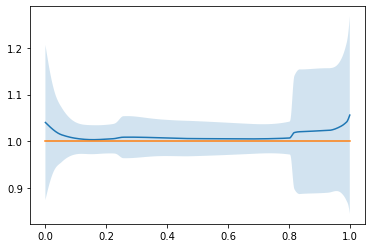

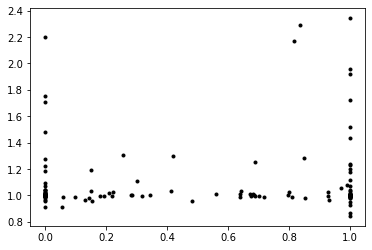

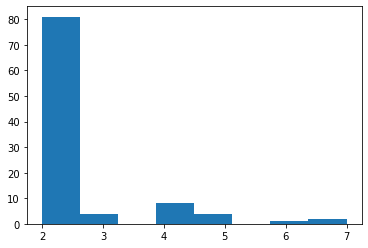

In [601]:
SR_interpolate_par = np.array([interpolate_SR(SR_all[-1][0], depth) for SR_all in SR_all_para])
n_SR_par = np.array([len(SR_all[-1][0][0]) for SR_all in SR_all_para])
SR_par = [SR_all[-1][0] for SR_all in SR_all_para]
# SR_interpolate_par.shape
mean_SR = SR_interpolate_par.mean(axis=0); std_SR = SR_interpolate_par.std(axis=0)
plt.plot(depth, mean_SR)
plt.fill_between(depth, mean_SR-std_SR, mean_SR+std_SR, alpha=0.2)
plt.plot(depth, SR)
plt.figure()
[plt.plot(*SRi, ".", color="black") for SRi in SR_par]
plt.figure()
plt.hist(n_SR_par, bins=8)


(array([38., 28., 16., 18.]),
 array([2., 3., 4., 5., 6.]),
 <BarContainer object of 4 artists>)

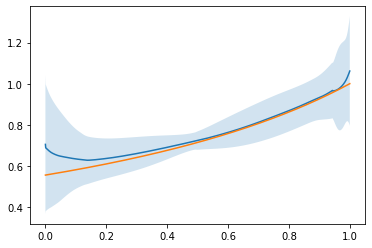

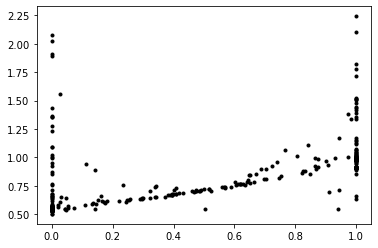

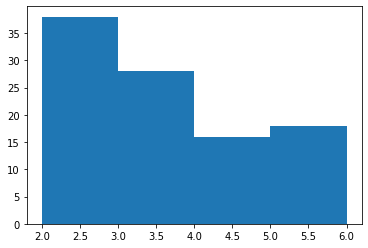

In [607]:
SR_interpolate_par = np.array([interpolate_SR(SR_all[-1][0], depth) for SR_all in SR_all_para])
n_SR_par = np.array([len(SR_all[-1][0][0]) for SR_all in SR_all_para])
SR_par = [SR_all[-1][0] for SR_all in SR_all_para]
# SR_interpolate_par.shape
mean_SR = SR_interpolate_par.mean(axis=0); std_SR = SR_interpolate_par.std(axis=0)
plt.plot(depth, mean_SR)
plt.fill_between(depth, mean_SR-std_SR, mean_SR+std_SR, alpha=0.2)
plt.plot(depth, SR)
plt.figure()
[plt.plot(*SRi, ".", color="black") for SRi in SR_par]
plt.figure()
plt.hist(n_SR_par, bins=4)
